# **Task \#2**: Machine Learning MC886/MO444
##**Classical Machine Learning Techniques**##

In [1]:
print('Daniel Gardin Gratti ' + '214729')
print('Beatriz Cardoso Nascimento' + ' 247403')

Daniel Gardin Gratti 214729
Beatriz Cardoso Nascimento 247403


## Objective:

To explore **Linear Regression** and **Logistic Regression** alternatives and come up with the best possible model for the problems, at the same time avoiding overfitting (and also underfitting). In this work, we will train a model that use medical records from patients to predict patient survival.

## Dataset

The purpose of this dataset is to predict the patients' survival from medical records. These data is available in [Google Sheets](https://docs.google.com/spreadsheets/d/18-PlYBnwD7yJoyGJOsaB5Wydc2iTG9sSnbuuV4t4efE/edit?usp=sharing), consisting in 299 patients with heart failure collected in 2015. 

**Data Dictionary**:

- **AGE**: Age of the patient (years);

- **ANAEMIA**: Decrease of red blood cells or hemoglobin (boolean);

- **HIGH BLODD PRESSURE**: If the patient has hypertension (boolean);

- **CREATININE PHOSPHOKINASE (CPK)**: Level of the CPK enzyme in the blood (mcg/L);

- **DIABETES**: If the patient has diabetes (boolean);

- **EJECTION FRACTION**: Percentage of blood leaving the heart at each contraction (percentage);

- **PLATELETS**: Platelets in the blood (kiloplatelets/mL);

- **SEX**: Woman or man (binary);

- **SERUM CREATININE**: Level of serum creatinine in the blood (mg/dL);

- **SERUM SODIUM**: Level of serum sodium in the blood (mEq/L);

- **SMOKING**: If the patient smokes or not (boolean);

- **TIME**: Follow-up period (days);

- **DEATH EVENT**: If the patient deceased during the follow-up period (boolean);

More information about the dataset: *Chicco, D., Jurman, G. Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone. BMC Med Inform Decis Mak 20, 16 (2020). https://doi.org/10.1186/s12911-020-1023-5*

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import random

# Determinando seeds
np.random.seed(42)
random.seed(42)

df = pd.read_csv('heart_dataset.csv')

df.head(5)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,DEATH_EVENT
0,75.0,No,582.0,No,20.0,1.0,265000.00,1.9,130.0,Female,No,1
1,55.0,No,7861.0,No,38.0,0.0,263358.03,1.1,136.0,Female,No,1
2,65.0,No,146.0,No,20.0,0.0,162000.00,1.3,129.0,Female,Yes,1
3,50.0,Yes,111.0,No,20.0,0.0,210000.00,1.9,137.0,Female,No,1
4,NaN,Yes,160.0,Yes,20.0,0.0,327000.00,2.7,116.0,Male,No,1


### Analysis


(0.5 points) This part of the assignmente aims to analyze the dataset and preprocess the data for the models. To do so, a fews things to be considered: 


*   Are there any outliers?
*   Are there missing values?
*   How will you handle categorical variables?

In [3]:
CATEG_LABELS = ['female', 'anaemia', 'diabetes', 'high_blood_pressure', 'smoking']
NUM_LABELS = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']

In [4]:
df.isna().sum(axis=0)

age                         4
anaemia                     1
creatinine_phosphokinase    2
diabetes                    2
ejection_fraction           2
high_blood_pressure         2
platelets                   3
serum_creatinine            2
serum_sodium                1
sex                         5
smoking                     0
DEATH_EVENT                 0
dtype: int64

Sim, existem valores faltantes no dataset, distrubuídos de acordo com a tabela acima. Para minimizar o impacto da ausência desses valores no nosso modelo, substituímos os valores faltantes pela mediana e pela moda.

In [5]:
df.fillna({
    'age': df['age'].median(),
    'anaemia': df['anaemia'].value_counts().idxmax(),
    'creatinine_phosphokinase': df['creatinine_phosphokinase'].median(),
    'diabetes': df['diabetes'].value_counts().idxmax(),
    'ejection_fraction': df['ejection_fraction'].median(),
    'high_blood_pressure': df['high_blood_pressure'].value_counts().idxmax(),
    'platelets': df['platelets'].median(),
    'serum_creatinine': df['serum_creatinine'].median(),
    'serum_sodium': df['serum_sodium'].median(),
    'sex': df['sex'].value_counts().idxmax(),
}, inplace=True)

Para lidar com as variáveis categóricas, utilizaremos a técnica One Hot Encoding. Nessa técnica, representamos variáveis categóricas como valores numéricos, como segue:

In [6]:

df["female"]   =(df["sex"] == "Female").astype(int)
df = df.drop(columns=['sex'])
df["anaemia"]  = (df["anaemia"] == "Yes").astype(int)
df["diabetes"] = (df["diabetes"] == "Yes").astype(int)
df["smoking"] = (df["smoking"] == "Yes").astype(int)
df["high_blood_pressure"] = df["high_blood_pressure"].apply(int)


In [7]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=len(NUM_LABELS))
for i, var in enumerate(NUM_LABELS):
    fig.add_trace(
        go.Box(y=df[var],
        name=var),
        row=1, col=i+1
    )

fig.update_traces(boxpoints='all', jitter=.3)

Ao fazer o boxplot das features do dataset, podemos observar que existem outliers, pois existem pontos muito distantes da média de cada feature.

## Linear Regression

(0.75 points) This part of the assigment aims to predict the level of serum creatinine in the blod based on their medical records. 

*   Do we need to split the data into train, valid and test? How?
*   Do we need to normalize the data? How? The normalization is equal to train, valid and test split?
* **Target value: serum_creatinine**.

Obs: drop the DEATH_EVENT column.

In [8]:
X = df.drop(columns=['DEATH_EVENT', 'serum_creatinine'])
y = df['serum_creatinine']

NUM_LABELS_REGRESSION = NUM_LABELS.copy()
NUM_LABELS_REGRESSION.remove('serum_creatinine')

Sim, precisamos dividir os dados em treinamento, validação e teste. Utilizaremos a função train_test_split da biblioteca sklearn. Primeiramente, dividimos o dataset em conjunto de treinamento (X_train, y_train) e conjunto de teste (X_test, y_test), onde o conjunto de teste tem 20% dos dados do dataset. Depois, dividimos o conjunto de treinamento em conjunto de treinamento (X_train, y_train) e conjunto de validação (X_val, y_val), onde o conjunto de treinamento após a divisão tem 80% dos dados do conjunto de treinamento original.

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val,  y_train, y_val  = train_test_split(X_train, y_train, test_size=0.2)

Precisamos normalizar os dados e para isso utilizaremos a normalização Z Score, como segue:

In [11]:
class ZScore:
    def __init__(self):
        self.mean = 0
        self.std  = 1

    def fit(self, X, rows=None):
        if rows is None:
            self.mean = X.mean(axis=0)
            self.std  = X.std(axis=0)
        
        else:
            self.mean = X[rows].mean(axis=0)
            self.std  = X[rows].std(axis=0)

        return self
    
    def fit_transform(self, X, rows=None, epsilon=1e-8):
        target = X.copy()
        
        if rows is None:
            self.mean = X.mean(axis=0)
            self.std  = X.std(axis=0)
        
            target = (target - self.mean + epsilon)/(self.std + epsilon)

        else:
            self.mean = target[rows].mean(axis=0)
            self.std  = target[rows].std(axis=0)
        
            target[rows] = (target[rows] - self.mean + epsilon)/(self.std + epsilon)

        return target

    def transform(self, X, rows=None, epsilon=1e-8):
        target = X.copy()
        
        if rows is None:
            target = (target - self.mean)/(self.std + epsilon)

        else:
            target[rows] = (target[rows] - self.mean + epsilon)/(self.std + epsilon)

        return target

Os parâmetros da normalização são calculados no conjunto de treinamento e a mesma normalização é utilizada no conjunto de treinamento, validação e teste.

In [12]:
standardization = ZScore()

X_train = standardization.fit_transform(X_train, NUM_LABELS_REGRESSION)
X_val   = standardization.transform(X_val, NUM_LABELS_REGRESSION)
X_test  = standardization.transform(X_test, NUM_LABELS_REGRESSION)

### Activities

1. (0.5 points) Verify if there is any feature that has low correlation with the target variables. You can use the function [mutual_info_regression](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html) to check the importance of each feature. 

> *   Do we need all the features to predict the target value?
> *   What happens if we drop the low correlation features?

/tmp/ipykernel_226264/3881673107.py:8: UserWarning:

FixedFormatter should only be used together with FixedLocator



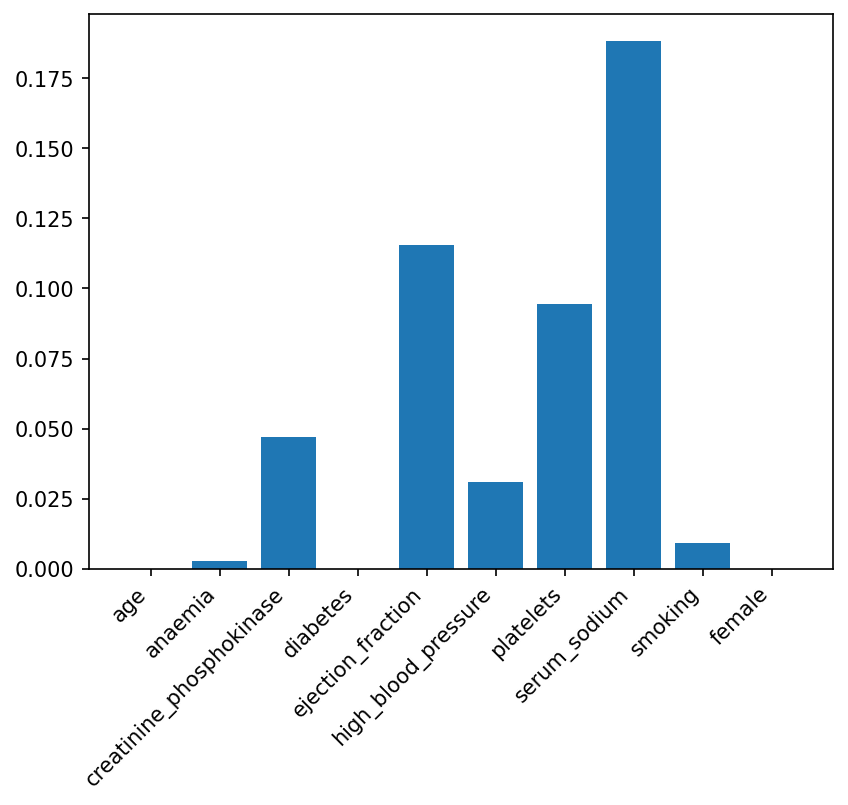

In [13]:
from sklearn.feature_selection import mutual_info_regression

fig, ax = plt.subplots(dpi=150)

correlation = mutual_info_regression(X_train, y_train, discrete_features=~np.isin(X_train.columns, NUM_LABELS_REGRESSION), random_state=42)

ax.bar(X.columns.values, correlation)
ax.set_xticklabels(X.columns.values, rotation=45, ha='right')

plt.show()

In [14]:
correlated_labels = X.columns.values[correlation > 0.05]

X_train = X_train[correlated_labels].to_numpy()
X_val   = X_val[correlated_labels].to_numpy()
X_test  = X_test[correlated_labels].to_numpy()

y_train = y_train.to_numpy()
y_val   = y_val.to_numpy()
y_test  = y_test.to_numpy()

In [15]:
fig = make_subplots(rows=1, cols=len(correlated_labels))
for i, var in enumerate(correlated_labels):
    fig.add_trace(
        go.Box(y=X_train[:, i],
        name=var),
        row=1, col=i+1
    )

fig.update_traces(boxpoints='all', jitter=.3)

> What are the conclusions? (1-2 paragraphs)

Não precisamos de todas as features para prever o valor desejado. O procedimento de reduzir o número de features utilizadas no modelo é chamado de feature selection, e é utilizado para reduzir o custo computacional do algoritmo e melhorar sua performance. Com esse método, features redundantes ou que são irrelevantes para o valor alvo são ignoradas. Ocorre melhora de performance no modelo porque, do contrário, como não temos regularização, o modelo tentará aprender padrões a partir de features não correlacionadas, o que é computacionalmente caro e pode impactar negativamente nos resultados obtidos.

2. (2.0 points) Perform Linear Regression. You should implement your solution and compare it with ```sklearn.linear_model.SGDRegressor``` (linear model fitted by minimizing a regularized empirical loss with SGD, http://scikit-learn.org).

In [16]:
def MSE(y, y_hat):
    n_samples = len(y)
    return np.sum((y - y_hat)**2)/(2*n_samples) 

In [17]:
class LinearRegression:
    def __init__(self, learning_rate=1., max_iter=-1):
        self.max_iter        = max_iter
        self.learning_rate   = learning_rate
        self.weights         = None
    
    def predict(self, X):
        return X @ self.weights
    
    def fit(self, X, y, *validation_tuple, batch_size=None, summary=True):
        n_iter = 0

        n_samples, n_features = X.shape
        n_output = y.shape[1] if len(y.shape) > 1 else 1

        history  = []
        val_hist = []

        if self.weights is None:
            self.weights = np.zeros((n_features, n_output)) if len(y.shape) > 1 else np.zeros(n_features)

        if validation_tuple:
            X_val, y_val = validation_tuple

        if batch_size is None or batch_size > n_samples:
            batch_size = n_samples

        n_batches = n_samples // batch_size
        while n_iter < self.max_iter:

            loss = 0

            shuffled_indices = np.random.permutation(n_samples)

            for i in range(n_batches):
                batch_indices = shuffled_indices[i*batch_size : min((i+1)*batch_size, n_samples)]

                X_train = X[batch_indices]
                y_train = y[batch_indices]

                batch_current_size = len(batch_indices)

                y_hat = X_train @ self.weights

                error = y_hat - y_train

                weights_grad = (X_train.T @ error)/batch_current_size

                self.weights = self.weights - self.learning_rate * weights_grad

                loss += np.sum(error**2)/(2*batch_current_size)

            history.append(loss/n_batches)

            n_iter += 1

            if summary:
                print(f"Epoch {n_iter : <3d}: Training loss    {loss/n_batches :.5f}")

            if validation_tuple:
                error = (X_val @ self.weights) - y_val

                loss = np.sum(error**2)/(2*y_val.shape[0])

                val_hist.append(loss)

                if summary:
                    print(" "*10, f"Validation loss {loss : .5f}")
    
            if summary: print()

        return history, val_hist if validation_tuple else history


    def loss(self, X, y):
        y_hat = (X @ self.weights)

        return MSE(y, y_hat)


    def score(self, X, y):
        n_samples = len(y)

        y_mean = y.mean(axis=0)

        mean_loss = np.sum((y - y_mean)**2)/(2*n_samples)

        return 1 - self.loss(X, y)/mean_loss

In [18]:
from sklearn.preprocessing import PolynomialFeatures

def train_model(learning_rate, polynomial_degree=1, verbose=True, max_iter=200):
    global X_train, X_val, y_train, y_val

    zscore = ZScore()

    poly = PolynomialFeatures(polynomial_degree)

    Xt = poly.fit_transform(X_train[:, 1:])
    Xv   = poly.transform(X_val[:, 1:])

    Xt = zscore.fit_transform(Xt, rows=range(1, poly.n_output_features_))
    Xv   = zscore.transform(Xv, rows=range(1, poly.n_output_features_))
    
    lin = LinearRegression(learning_rate, max_iter=max_iter)
    history, val_history = lin.fit(Xt, y_train, Xv, y_val, summary=verbose)

    return history, val_history, lin

In [19]:
history, val_history, model = train_model(learning_rate=0.01)

Epoch 1  : Training loss    1.52811
           Validation loss  1.15253

Epoch 2  : Training loss    1.50831
           Validation loss  1.13238

Epoch 3  : Training loss    1.48891
           Validation loss  1.11264

Epoch 4  : Training loss    1.46989
           Validation loss  1.09331

Epoch 5  : Training loss    1.45125
           Validation loss  1.07437

Epoch 6  : Training loss    1.43299
           Validation loss  1.05583

Epoch 7  : Training loss    1.41509
           Validation loss  1.03766

Epoch 8  : Training loss    1.39754
           Validation loss  1.01987

Epoch 9  : Training loss    1.38035
           Validation loss  1.00244

Epoch 10 : Training loss    1.36349
           Validation loss  0.98537

Epoch 11 : Training loss    1.34698
           Validation loss  0.96865

Epoch 12 : Training loss    1.33079
           Validation loss  0.95227

Epoch 13 : Training loss    1.31492
           Validation loss  0.93623

Epoch 14 : Training loss    1.29938
           Vali

In [45]:
# TODO: Linear Regression. You can use scikit-learn libraries.
from sklearn.linear_model import SGDRegressor

regressor = SGDRegressor(learning_rate='constant', eta0=0.01, verbose=1)

regressor.fit(X_train, y_train)

print(f'\nMSE Sklearn: {MSE(regressor.predict(X_val), y_val)}')
print(f'MSE LinearRegression: {MSE(model.predict(X_val), y_val)}')

-- Epoch 1
Norm: 0.15, NNZs: 2, Bias: 0.291266, T: 191, Avg. loss: 0.113511
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.16, NNZs: 2, Bias: 0.325304, T: 382, Avg. loss: 0.094175
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.20, NNZs: 2, Bias: 0.329777, T: 573, Avg. loss: 0.093664
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.20, NNZs: 2, Bias: 0.351978, T: 764, Avg. loss: 0.093766
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 0.18, NNZs: 2, Bias: 0.341126, T: 955, Avg. loss: 0.094235
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 0.17, NNZs: 2, Bias: 0.336273, T: 1146, Avg. loss: 0.093522
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 0.18, NNZs: 2, Bias: 0.321990, T: 1337, Avg. loss: 0.094158
Total training time: 0.00 seconds.
Convergence after 7 epochs took 0.00 seconds

MSE Sklearn: 0.08682688889636063
MSE LinearRegression: 0.13541666666666666


> What are the conclusions? (1-2 paragraphs)

Ao implementar nosso modelo e comparar o MSE com o do modelo nativo ao Sklearn, podemos observar que o desempenho é bastante próximo. 

3. (0.5 points) Plot the cost function vs. number of epochs in the training/validation set and analyze the model. 

[]

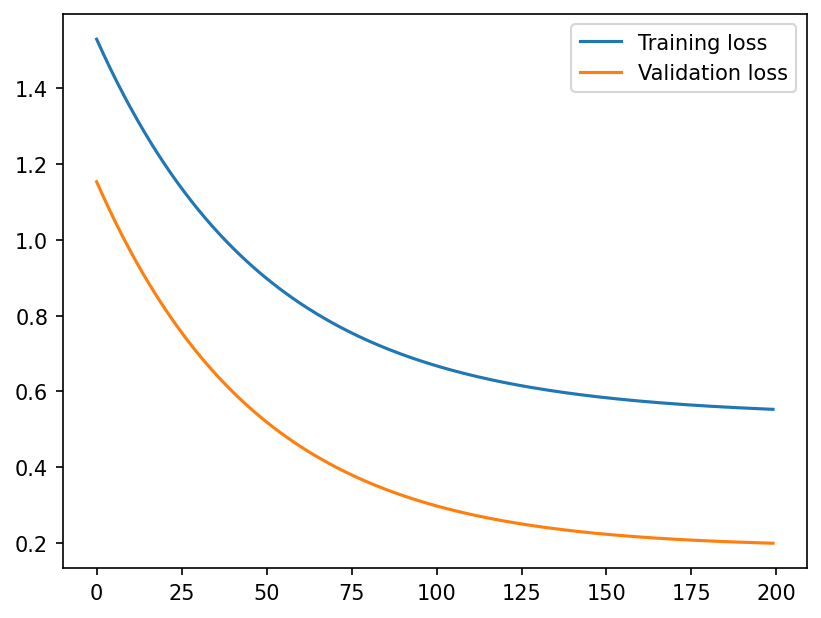

In [21]:
fig, ax = plt.subplots(dpi=150)

ax.plot(history, label="Training loss")
ax.plot(val_history, label="Validation loss")

ax.legend()

plt.plot()

> What are the conclusions? (1-2 paragraphs)

No gráfico fica claro que, após a 600ª época a função de custo tanto no treinamento quanto na validação fica estável. Além disso, nesse caso, a função custo alcançou valores maiores no conjunto de treinamento que na validação, o que não é usual. 

4. (0.75 points) Use different learning rates when optimizing the model. You can use the model that you implemented or the model from scikit-learn.

> If you prefer to use the SGDRegressor from scikit-learn, use the parameter ```learning_rate='constant'``` and change the ```eta0```.

In [22]:
rates = [2**i for i in range(-10, 2)]

train_error = []
val_error = []

for rate in rates:
    history, val_history, _ = train_model(rate, verbose=False, max_iter=100)

    train_error.append(np.min(history))
    val_error.append(np.min(val_history))

best = rates[np.argmin(val_error)]

[]

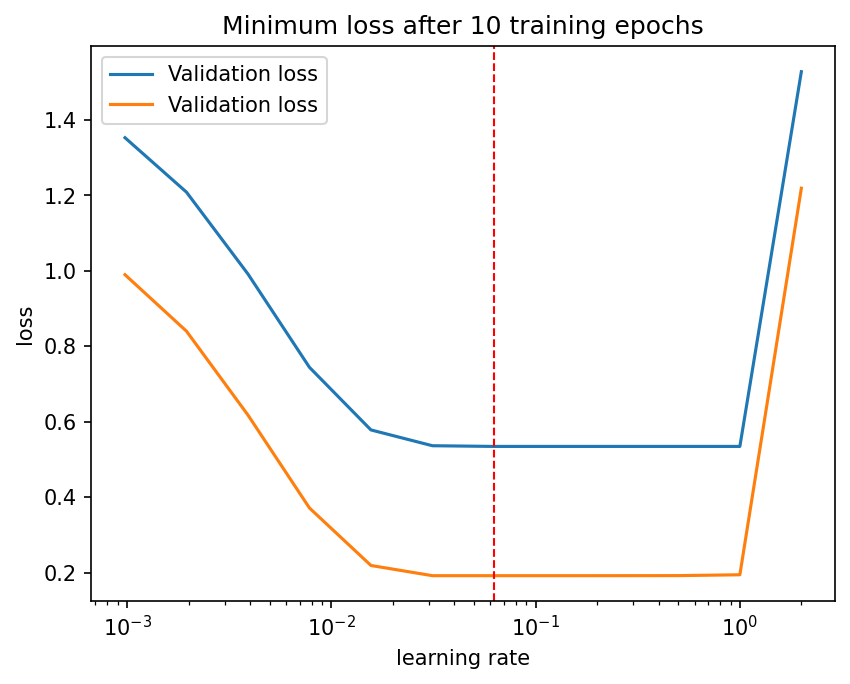

In [23]:
fig, ax = plt.subplots(dpi=150)

ax.set_title("Minimum loss after 10 training epochs")
ax.plot(rates, train_error, label="Validation loss")
ax.plot(rates, val_error, label="Validation loss")
ax.set_xlabel('learning rate')
ax.set_ylabel('loss')
ax.set_xscale('log')
ax.axvline(best, linestyle='--', linewidth=1, color='r')
ax.legend()
plt.plot()

In [24]:
rates = np.linspace(best/2, best*2, num=10)

train_error = []
val_error = []

for rate in rates:
    history, val_history, _ = train_model(rate, verbose=False)

    train_error.append(np.min(history))
    val_error.append(np.min(val_history))

best = rates[np.argmin(val_error)]

[]

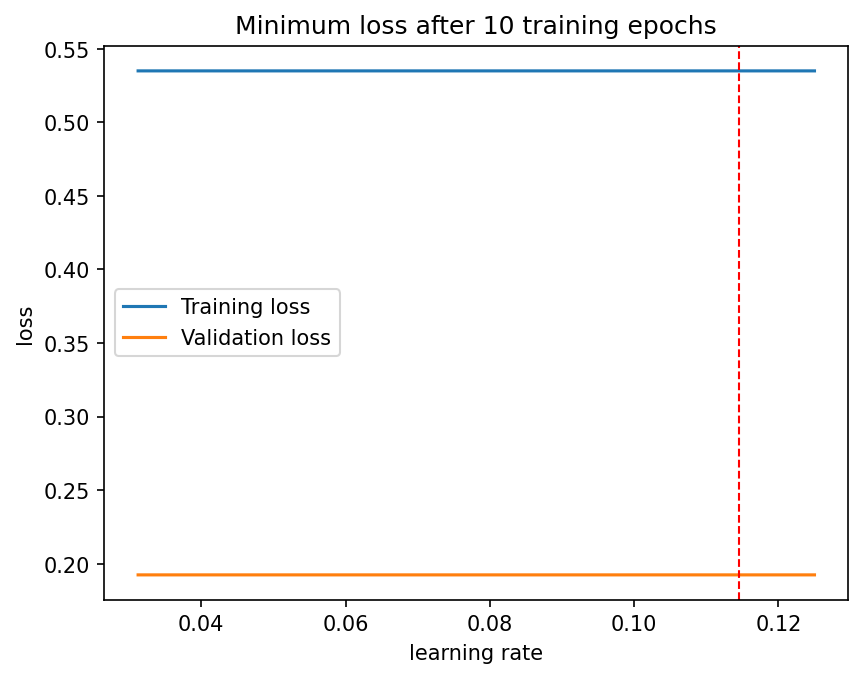

In [25]:
fig, ax = plt.subplots(dpi=150)

ax.set_title("Minimum loss after 10 training epochs")
ax.plot(rates, train_error, label="Training loss")
ax.plot(rates, val_error, label="Validation loss")
ax.set_xlabel('learning rate')
ax.set_ylabel('loss')
ax.axvline(best, linestyle='--', linewidth=1, color='r')
ax.legend()
plt.plot()

In [26]:
history, val_history, _ = train_model(learning_rate=best)

Epoch 1  : Training loss    1.52811
           Validation loss  0.95045

Epoch 2  : Training loss    1.31320
           Validation loss  0.77730

Epoch 3  : Training loss    1.14480
           Validation loss  0.64279

Epoch 4  : Training loss    1.01284
           Validation loss  0.53839

Epoch 5  : Training loss    0.90944
           Validation loss  0.45747

Epoch 6  : Training loss    0.82842
           Validation loss  0.39484

Epoch 7  : Training loss    0.76492
           Validation loss  0.34644

Epoch 8  : Training loss    0.71517
           Validation loss  0.30912

Epoch 9  : Training loss    0.67619
           Validation loss  0.28040

Epoch 10 : Training loss    0.64563
           Validation loss  0.25837

Epoch 11 : Training loss    0.62169
           Validation loss  0.24151

Epoch 12 : Training loss    0.60293
           Validation loss  0.22866

Epoch 13 : Training loss    0.58823
           Validation loss  0.21891

Epoch 14 : Training loss    0.57671
           Vali

[]

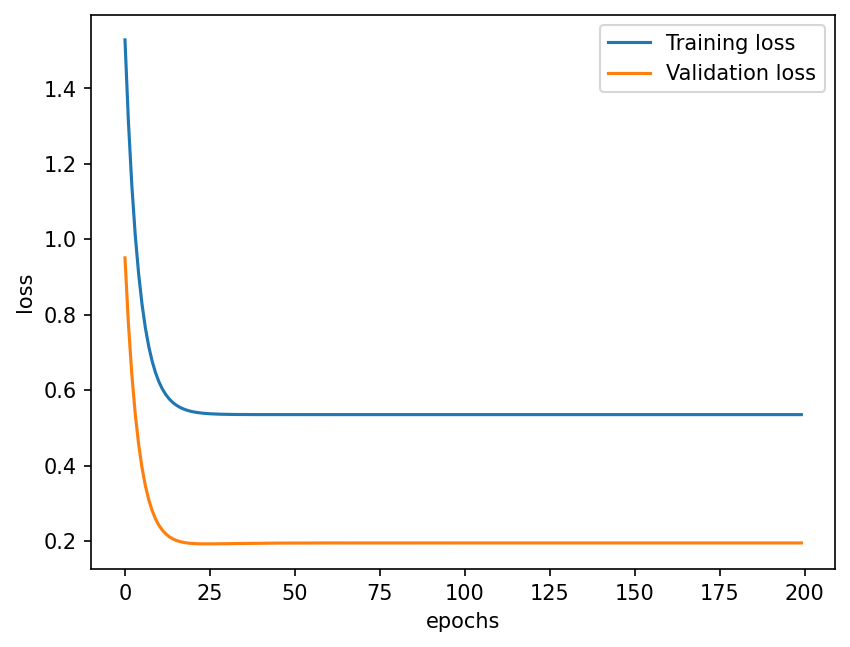

In [27]:
fig, ax = plt.subplots(dpi=150)

ax.plot(history, label="Training loss")
ax.plot(val_history, label="Validation loss")

ax.set_xlabel('epochs')
ax.set_ylabel('loss')

ax.legend()
plt.plot()

> What are the conclusions? (1-2 paragraphs)

5. (0.5 points) Sometimes, we need some more complex function to make good prediction. Evaluate a [Polynomial Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) model. 

In [28]:
history, val_history, _ = train_model(learning_rate=0.1, polynomial_degree=2)


Epoch 1  : Training loss    1.52811
           Validation loss  0.68996

Epoch 2  : Training loss    1.09781
           Validation loss  0.62396

Epoch 3  : Training loss    0.96112
           Validation loss  0.61006

Epoch 4  : Training loss    0.87997
           Validation loss  0.60513

Epoch 5  : Training loss    0.82348
           Validation loss  0.59703

Epoch 6  : Training loss    0.78084
           Validation loss  0.58306

Epoch 7  : Training loss    0.74684
           Validation loss  0.56405

Epoch 8  : Training loss    0.71876
           Validation loss  0.54177

Epoch 9  : Training loss    0.69504
           Validation loss  0.51788

Epoch 10 : Training loss    0.67473
           Validation loss  0.49365

Epoch 11 : Training loss    0.65720
           Validation loss  0.46996

Epoch 12 : Training loss    0.64196
           Validation loss  0.44734

Epoch 13 : Training loss    0.62868
           Validation loss  0.42611

Epoch 14 : Training loss    0.61706
           Vali

[]

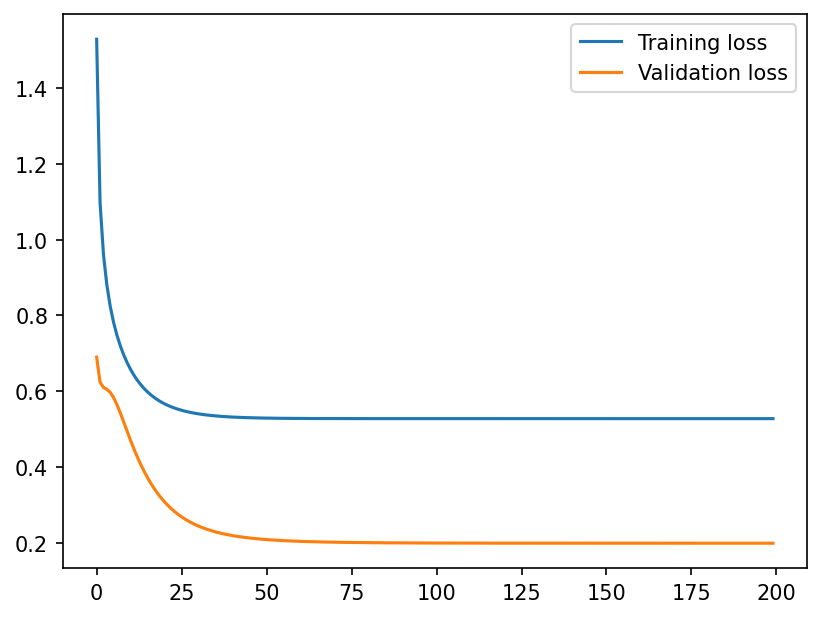

In [29]:
fig, ax = plt.subplots(dpi=150)

ax.plot(history, label="Training loss")
ax.plot(val_history, label="Validation loss")

ax.legend()
plt.plot()

> What are the conclusions? (1-2 paragraphs)

6. (0.5 points) Pick **your best model**, based on your validation set, and predict the target values for the test set.

In [30]:
def linear_search(fun, init_interval, tol):
    PHI = (3 - np.sqrt(5))/2

    xstart, xend = init_interval
    fstart, fend = fun(xstart), fun(xend)

    xnew = xstart + PHI * (xend - xstart)
    fnew = fun(xstart)

    while fstart <= fnew <= fend:
        xend, fend = xnew, fnew
        xnew, fnew = xstart, fstart

        xstart = xend - (xend - xnew)/PHI
        fstart = fun(xstart)
        
    while fstart >= fnew >= fend:
        xstart, fstart = xnew, fnew
        xnew  , fnew   = xend, fend

        xend = xstart + (xnew - xstart)/PHI
        fend = fun(xend)

    while np.any((xend - xstart) > tol):
        xtry = xend - PHI * (xend - xstart)
        ftry = fun(xtry)

        if fnew > ftry:
            xstart, fstart = xnew, fnew
            xnew  , fnew   = xtry, ftry

            xtry = xend - PHI * (xend - xstart)
            ftry = fun(xtry)
        
        else:
            xend, fend = xtry, ftry
            xtry, ftry = xnew, fnew

            xnew = xstart + PHI * (xend - xstart)
            fnew = fun(xnew)

    return (xtry + xnew)/2

[]

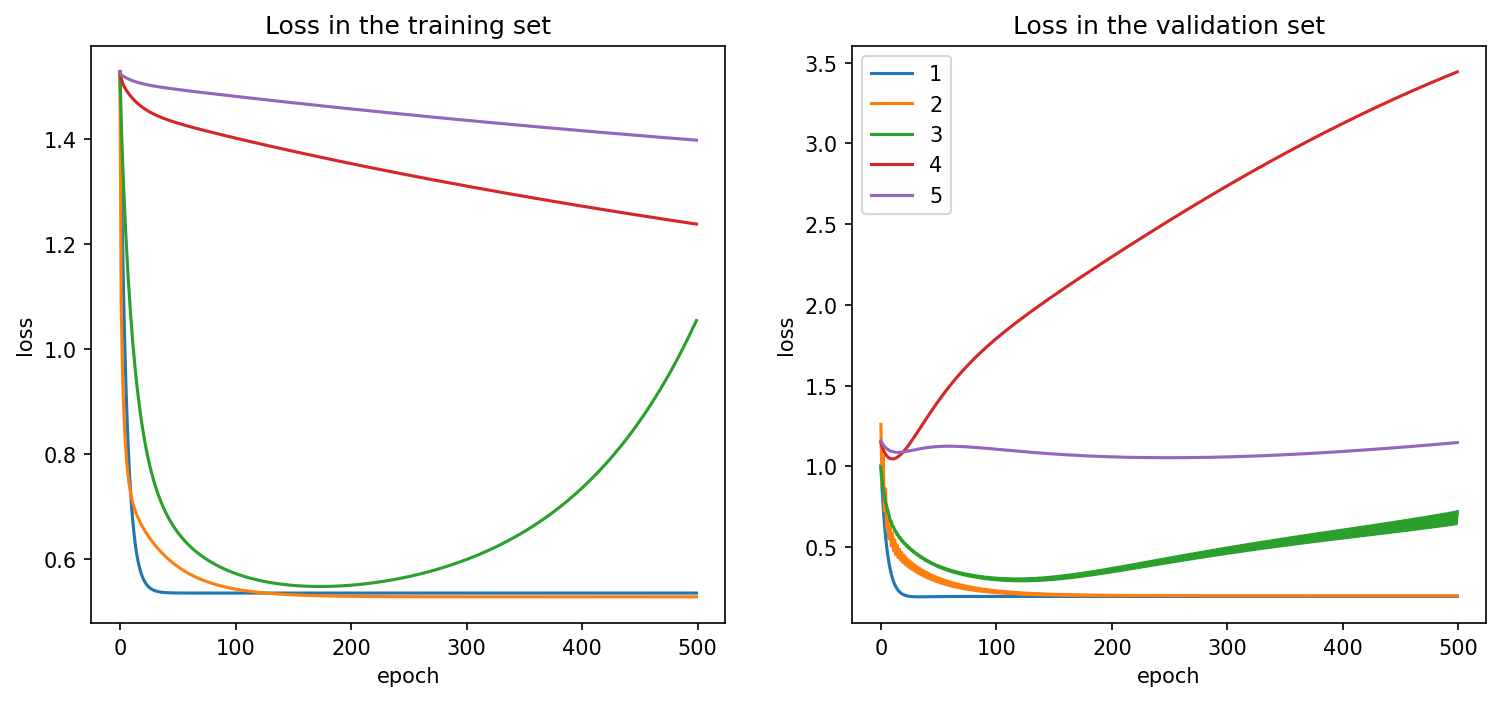

In [31]:
fig, ax = plt.subplots(ncols=2, figsize=(12,5) ,dpi=150)

ax[0].set_title("Loss in the training set")
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')

ax[1].set_title("Loss in the validation set")
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('loss')

for degree in range(1, 6):
    best_lr = linear_search(lambda lr : np.min(train_model(lr, degree, verbose=False, max_iter=250)[1]), (0, 10**-(degree)), 1e-10)

    history, val_history, _ = train_model(best_lr, degree, verbose=False, max_iter=500)

    ax[0].plot(range(len(history)), history, label=degree)
    ax[1].plot(range(len(history)), val_history, label=degree)
    
ax[1].legend()
plt.plot()

## Logistic Regression

This part of the assigment aims to predict the patients survival based on their medical records. 

*   Do we need to split the data into train, valid and test? How?
*   Do we need to normalize the data? How? The normalization is equal to train, valid and test split?
* **Target value: DEATH EVENT**.

In [32]:
X = df.drop(columns=['DEATH_EVENT'])
y = df['DEATH_EVENT']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val,  y_train, y_val  = train_test_split(X_train, y_train, test_size=0.2)

1. (0.5 points) Verify if there is any feature that has low correlation with the target variables. You can use the function [mutual_info_classification](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html) to check the importance of each feature.

/tmp/ipykernel_226264/832985694.py:8: UserWarning:

FixedFormatter should only be used together with FixedLocator



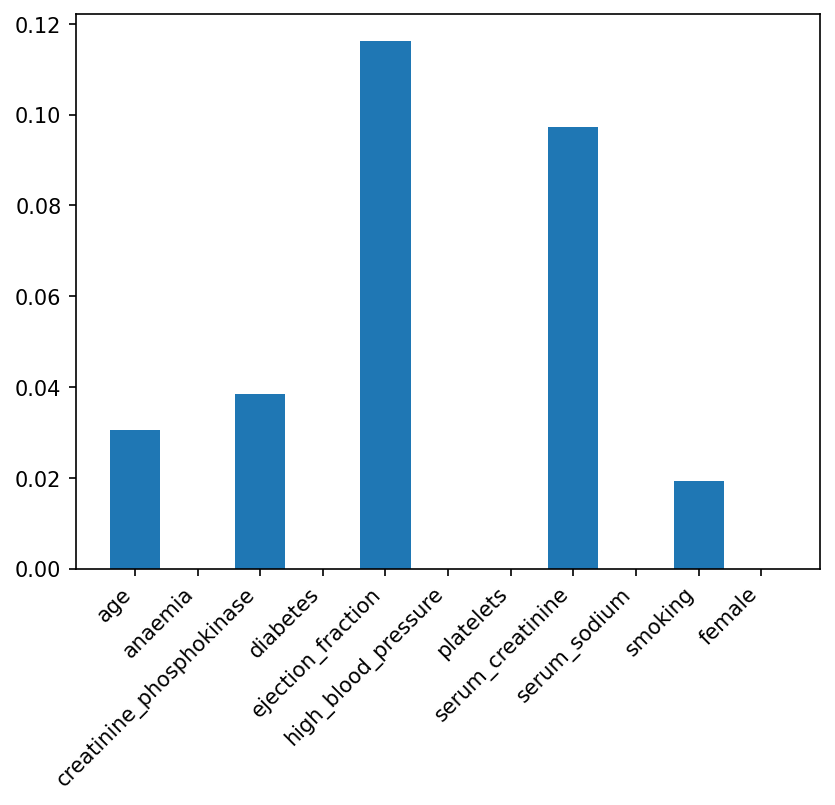

In [33]:
from sklearn.feature_selection import mutual_info_classif

correlation = mutual_info_classif(X_train, y_train) 

fig, ax = plt.subplots(dpi=150)

ax.bar(X.columns.values, correlation)
ax.set_xticklabels(X.columns.values, rotation=45, ha='right')

plt.show()

In [34]:
correlated_labels = X.columns.values[correlation > CORR_THRESHOLD]

X_train = X_train[correlated_labels].to_numpy()
X_val   = X_val[correlated_labels].to_numpy()
X_test  = X_test[correlated_labels].to_numpy()

y_train = y_train.to_numpy()
y_val   = y_val.to_numpy()
y_test  = y_test.to_numpy()

standardization = ZScore()
X_train = standardization.fit_transform(X_train)
X_val   = standardization.transform(X_val)
X_test  = standardization.transform(X_test)

> What are the conclusions? (1-2 paragraphs)

2. (2 points) Perform Multinomial Logistic Regression.

In [35]:
from sklearn.metrics import balanced_accuracy_score

[]

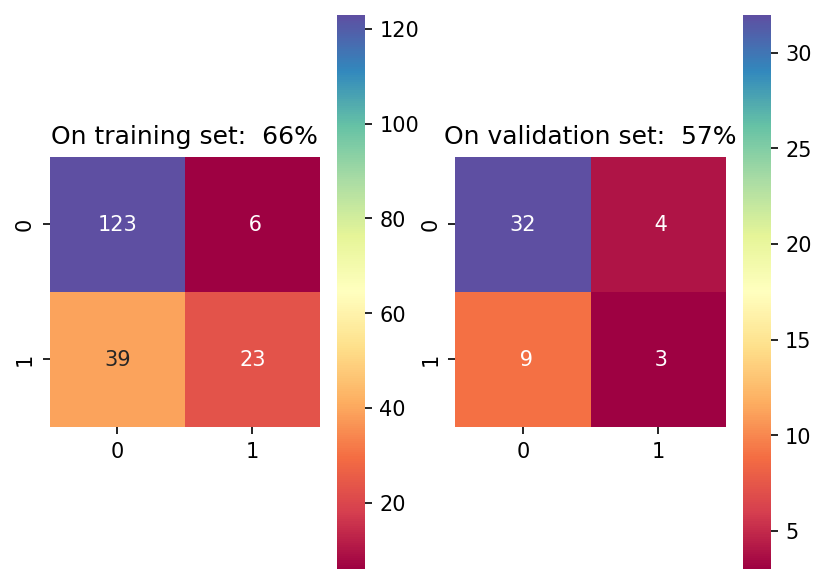

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

model = LogisticRegression()

model.fit(X_train, y_train)

def confusion_matrix(y_true, y_pred):
    matrix = np.zeros((2,2))

    for i in range(len(y_true)):
        matrix[y_true[i], y_pred[i]] += 1
    
    return matrix

fig, axs = plt.subplots(ncols=2, dpi=150)


y_pred = model.predict(X_train)

C = confusion_matrix(y_train, y_pred)
sns.heatmap(C, cmap='Spectral', annot=True, fmt='2.0f', square=True, ax=axs[0])
axs[0].set_title(f'On training set: {100* balanced_accuracy_score(y_train, y_pred) : 2.0f}%')

y_pred = model.predict(X_val)

C = confusion_matrix(y_val, y_pred)
sns.heatmap(C, cmap='Spectral', annot=True, fmt='2.0f', square=True, ax=axs[1])
axs[1].set_title(f'On validation set: {100* balanced_accuracy_score(y_val, y_pred) : 2.0f}%')
plt.plot()

> What are the conclusions? (1-2 paragraphs)


3. (1.5 points) Another factor that can alter the model result it's if the dataset is balanced:

*   The dataset is balanced ?
*   In this case, which technique is better: *oversampling* or *undersampling*?

Obs: You can use [RandomOverSampling](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html) and [RandomUnderSampling](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html#imblearn.under_sampling.RandomUnderSampler). But you can try others techniques.

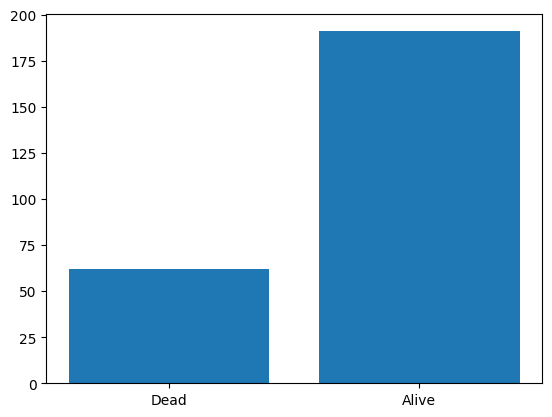

In [37]:
plt.bar(range(2), [np.count_nonzero(y_train), np.count_nonzero(~y_train)])
plt.xticks(range(2), labels=['Dead', 'Alive'])
plt.show()

In [38]:
from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler(random_state=32)

X_overtrain, y_overtrain = oversampler.fit_resample(X_train, y_train)

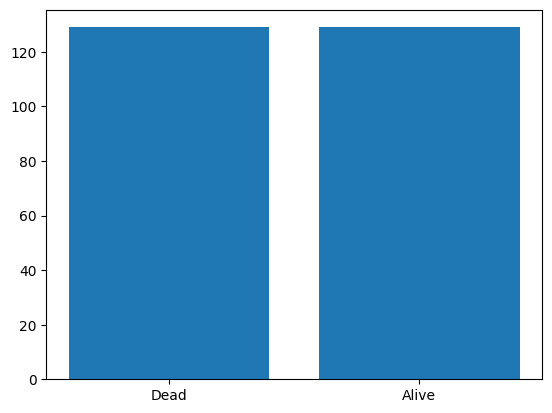

In [39]:
plt.bar(range(2), [np.count_nonzero(y_overtrain), np.count_nonzero(1 - y_overtrain)])
plt.xticks(range(2), labels=['Dead', 'Alive'])
plt.show()

[]

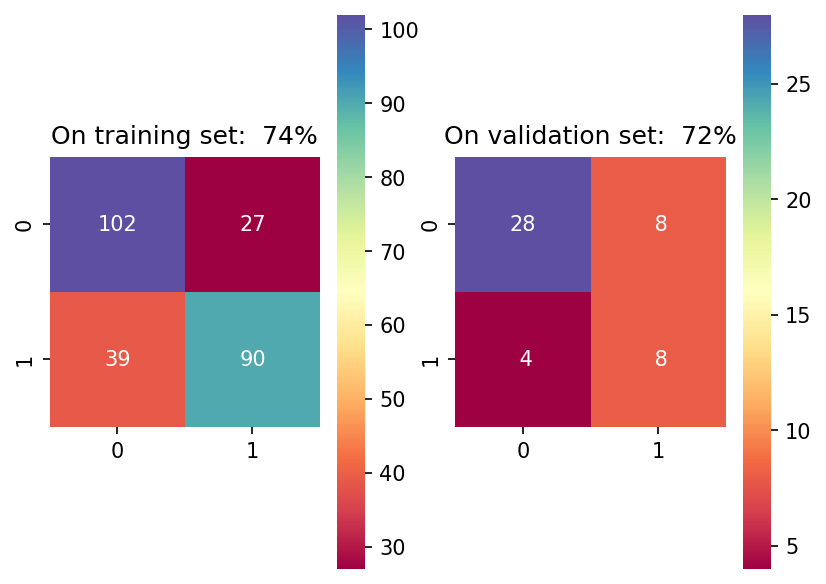

In [40]:
over_model = LogisticRegression()

over_model.fit(X_overtrain, y_overtrain)

def confusion_matrix(y_true, y_pred):
    matrix = np.zeros((2,2))

    for i in range(len(y_true)):
        matrix[y_true[i], y_pred[i]] += 1
    
    return matrix


fig, axs = plt.subplots(ncols=2, dpi=150)

y_pred = over_model.predict(X_overtrain)

C = confusion_matrix(y_overtrain, y_pred)
sns.heatmap(C, cmap='Spectral', annot=True, fmt='2.0f', square=True, ax=axs[0])
axs[0].set_title(f'On training set: {100* balanced_accuracy_score(y_overtrain, y_pred) : 2.0f}%')

y_pred = over_model.predict(X_val)

C = confusion_matrix(y_val, y_pred)
sns.heatmap(C, cmap='Spectral', annot=True, fmt='2.0f', square=True, ax=axs[1])
axs[1].set_title(f'On validation set: {100* balanced_accuracy_score(y_val, y_pred) : 2.0f}%')
plt.plot()

In [41]:
from imblearn.under_sampling import RandomUnderSampler

undersampler = RandomUnderSampler(random_state=32)

X_undertrain, y_undertrain = undersampler.fit_resample(X_train, y_train)

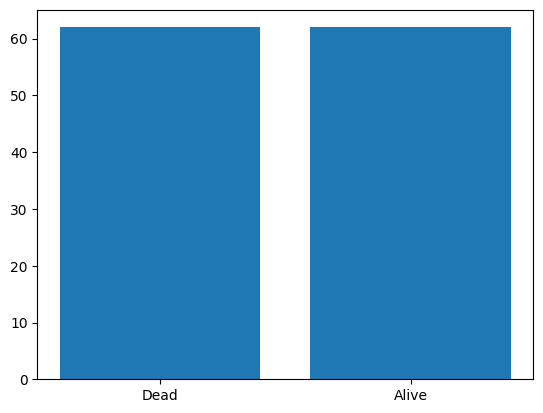

In [42]:
plt.bar(range(2), [np.count_nonzero(y_undertrain), np.count_nonzero(1 - y_undertrain)])
plt.xticks(range(2), labels=['Dead', 'Alive'])
plt.show()

[]

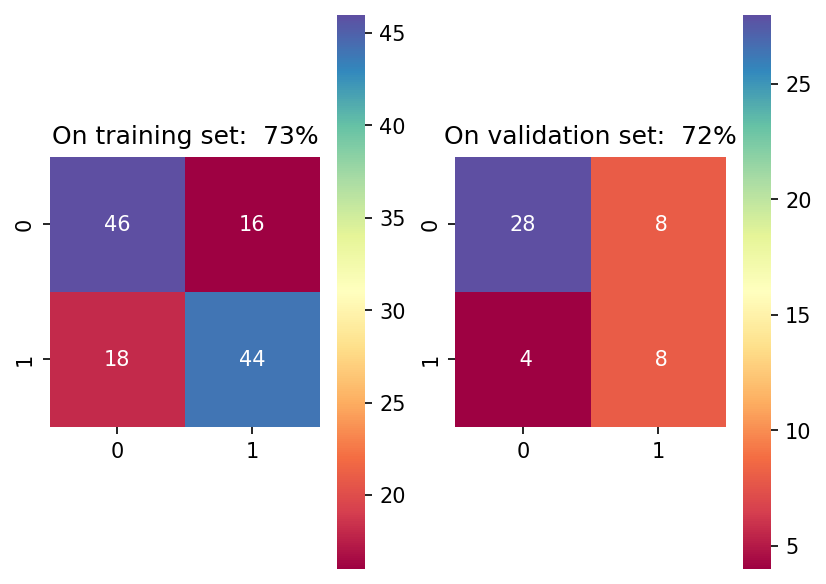

In [43]:
under_model = LogisticRegression()

under_model.fit(X_undertrain, y_undertrain)

def confusion_matrix(y_true, y_pred):
    matrix = np.zeros((2,2))

    for i in range(len(y_true)):
        matrix[y_true[i], y_pred[i]] += 1
    
    return matrix


fig, axs = plt.subplots(ncols=2, dpi=150)

y_pred = under_model.predict(X_undertrain)

C = confusion_matrix(y_undertrain, y_pred)
sns.heatmap(C, cmap='Spectral', annot=True, fmt='2.0f', square=True, ax=axs[0])
axs[0].set_title(f'On training set: {100* balanced_accuracy_score(y_undertrain, y_pred) : 2.0f}%')

y_pred = under_model.predict(X_val)

C = confusion_matrix(y_val, y_pred)
sns.heatmap(C, cmap='Spectral', annot=True, fmt='2.0f', square=True, ax=axs[1])
axs[1].set_title(f'On validation set: {100* balanced_accuracy_score(y_val, y_pred) : 2.0f}%')
plt.plot()

> What are the conclusions? (1-2 paragraphs)

4. (0.5 points) Pick **your best model** and plot the confusion matrix in the **test set**. 


/home/danielgardin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning:

overflow encountered in reduce

/tmp/ipykernel_226264/3282480334.py:51: RuntimeWarning:

overflow encountered in square

/tmp/ipykernel_226264/3282480334.py:63: RuntimeWarning:

overflow encountered in square

/tmp/ipykernel_226264/3282480334.py:51: RuntimeWarning:

overflow encountered in square

/tmp/ipykernel_226264/3282480334.py:63: RuntimeWarning:

overflow encountered in square

/home/danielgardin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning:

overflow encountered in reduce

/tmp/ipykernel_226264/3282480334.py:51: RuntimeWarning:

overflow encountered in square

/tmp/ipykernel_226264/3282480334.py:63: RuntimeWarning:

overflow encountered in square

/tmp/ipykernel_226264/3282480334.py:51: RuntimeWarning:

overflow encountered in square

/tmp/ipykernel_226264/3282480334.py:63: RuntimeWarning:

overflow encountered in square

/tmp/ipykernel_226264/

[]

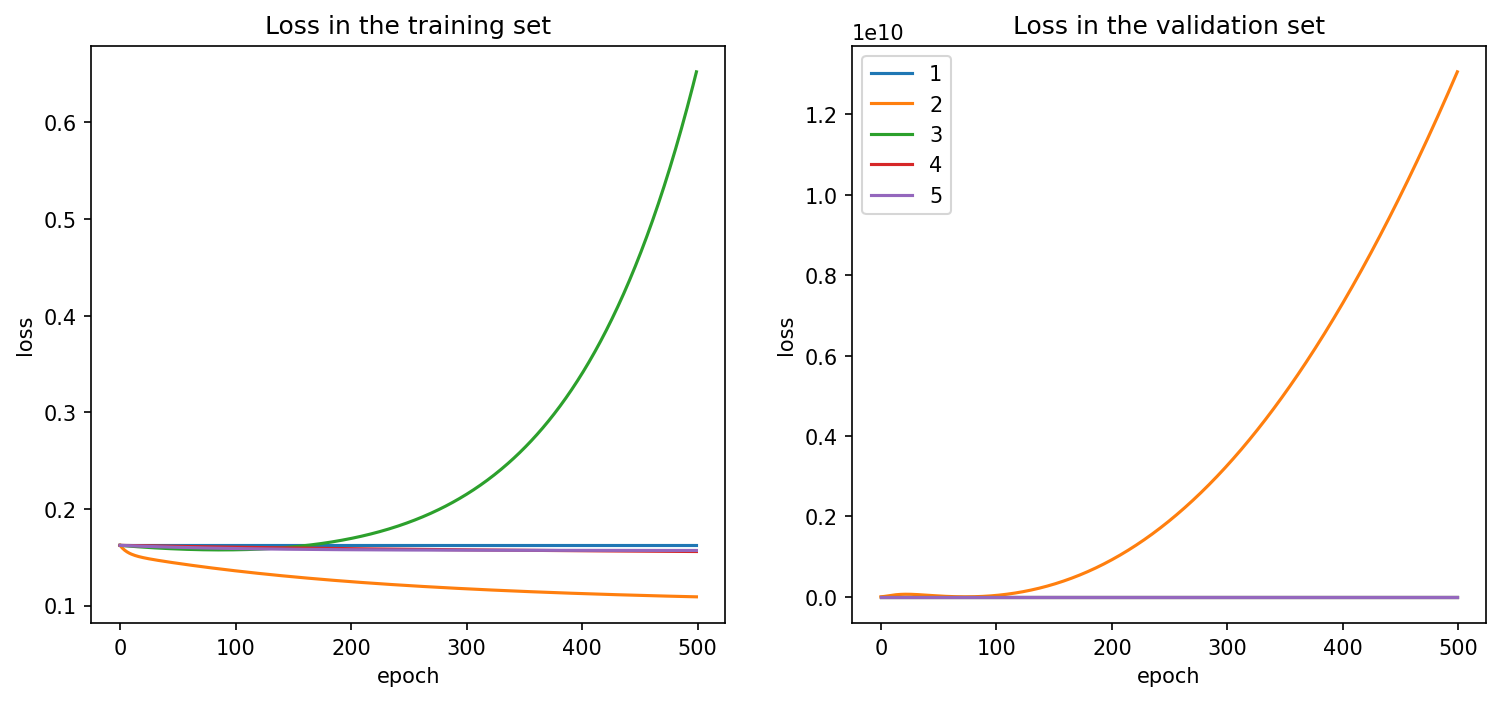

In [44]:
fig, ax = plt.subplots(ncols=2, figsize=(12,5) ,dpi=150)

ax[0].set_title("Loss in the training set")
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')

ax[1].set_title("Loss in the validation set")
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('loss')

for degree in range(1, 6):
    best_lr = linear_search(lambda lr : np.min(train_model(lr, degree, verbose=False, max_iter=250)[1]), (0, 10**-(degree)), 1e-10)

    history, val_history, _ = train_model(best_lr, degree, verbose=False, max_iter=500)

    ax[0].plot(range(len(history)), history, label=degree)
    ax[1].plot(range(len(history)), val_history, label=degree)
    
ax[1].legend()
plt.plot()

> What are the conclusions? (1-2 paragraphs)

## Deadline

Wednesday, April 19, 11:59 pm. 

Penalty policy for late submission: You are not encouraged to submit your assignment after due date. However, in case you do, your grade will be penalized as follows:
- April 20, 11:59 pm : grade * 0.75
- April 21, 11:59 pm : grade * 0.5
- April 22, 11:59 pm : grade * 0.25


## Submission

On Google Classroom, submit your Jupyter Notebook (in Portuguese or English).

**This activity is NOT individual, it must be done in pairs (two-person group).**